In [0]:
import pandas as pd
import numpy as np
import pickle
import gzip


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input



Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Generator with List, for CAE training

In [0]:
def gen_tr_1():
  while True: # each time will be one round going through all images
    im_num = 0
    batch_num = 0
      
    while True: #for one round through all images
      
      pixels=np.zeros(( 1 , 120, 160, 120))
      while (len(pixels)<3): 
              try:
                  path = '/content/drive/My Drive/PROCESSED/OAS3'
                  path += str(im_num).zfill(4)+'_data'
                  with open(path, 'rb') as f:
                        im= pickle.load(f)
                        pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                        im_num = im_num%1173
                        im_num += 1
              except:
                    im_num = im_num%1173
                    im_num += 1
    
                    pass
      batch_num += 1
      yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
              np.reshape(pixels[1:pixels.shape[0],:,:,:], (pixels.shape[0]-1,120,160,120,1)))

In [0]:
def gen_test_1():
  while True:
    im_num = 0
    batch_num = 0
    while True:
      pixels=np.zeros(( 1 , 120, 160, 120))
      while (len(pixels)<3): 
              try:
                  path = '/content/drive/My Drive/PROCESSED/OAS3'
                  im_num_inv = 1173 - im_num
                  path += str(im_num_inv).zfill(4)+'_data'
                  with open(path, 'rb') as f:
                        im= pickle.load(f)
                        pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                        im_num = im_num%1173
                        im_num += 1
              except:
                    im_num = im_num%1173
                    im_num += 1
                    pass
      batch_num += 1
      yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
              np.reshape(pixels[1:pixels.shape[0],:,:,:], (pixels.shape[0]-1,120,160,120,1)))

In [0]:
train_gen_1 = gen_tr_1()
test_gen_1 = gen_test_1()


### Generator for classifier

In [0]:
def convert_array(x):
    if x == "AD":
        return [1., 0.]
    elif x == "CN":
        return [0., 1.]
    else:
        return x

In [0]:
def gen_tr_c():
 while True:
  im_num = 0
  batch_num = 0
  while True:
    b_labels =[]
    pixels=np.zeros(( 1 , 120, 160, 120))
    while (len(pixels)<2): 
            try:
                path = '/content/drive/My Drive/PROCESSED/OAS3'
                path += str(im_num).zfill(4)+'_data'
                with open(path, 'rb') as f:
                      im= pickle.load(f)
                      pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                      if (im_num>1172): im_num = im_num%1173
                      im_num += 1
                      b_labels.append(im['diagnosis'])
            except:
                  if (im_num>1172): im_num = im_num%1173
                  im_num += 1
                  pass   
    batch_num += 1
    b_l = list(map( convert_array, b_labels))
    b_l = np.reshape(b_l, (len(b_l),2))
    b_l = b_l.astype('float32')
    yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
            b_l)

In [0]:
def gen_test_c():
 while True:
  im_num = 0
  batch_num = 0
  while True:
    b_labels =[]
    pixels=np.zeros(( 1 , 120, 160, 120))
    while (len(pixels)<2): 
            try:
                path = '/content/drive/My Drive/PROCESSED/OAS3'
                im_num_inv = 1173 - im_num
                path += str(im_num_inv).zfill(4)+'_data'
                with open(path, 'rb') as f:
                      im= pickle.load(f)
                      pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                      if (im_num>1172): im_num = im_num%1173
                      im_num += 1
                      b_labels.append(im['diagnosis'])
            except:
                  if (im_num>1172): im_num = im_num%1173
                  im_num += 1
                  pass
    batch_num += 1
    b_l = list(map( convert_array, b_labels))
    b_l = np.reshape(b_l, (len(b_l),2))
    b_l = b_l.astype('float32')
    yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
            b_l)

In [0]:
class_tr_gen = gen_tr_c()
class_test_gen = gen_test_c()

#### Building Encoder

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input


input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
encoded= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

#x = Flatten()(x)

#x = Dense(32, activation='selu')(x)
#x= Dense(16, activation='selu')(x)
#encoded = Dense(2, activation='selu')(x)


encoder=Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 30, 10)    0   

In [12]:
encoded_shape

(None, 15, 20, 15, 10)

#### Building decoder

In [13]:
encoded_input= Input(shape=(encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))
#x = Dense(16, activation='selu')(encoded_input)
#x= Dense(32, activation='selu')(x)
#x= Dense(np.prod(encoded_shape[1:]))(x)
#x= Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(encoded_input)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 20, 15, 10)    0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 15, 20, 15, 10)    2710      
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 40, 30, 10)    0         
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 30, 40, 30, 10)    2710      
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 80, 60, 10)    0   

#### Building Autoencoder

In [14]:
autoencoder= Model(input_img, decoder(encoder(input_img)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
e_s= EarlyStopping(monitor='val_loss', mode='min', patience=20)


In [0]:
mcp_save = ModelCheckpoint('best_cae.h5', save_best_only=True, monitor='val_loss', mode='min')

In [18]:
cae_hist= autoencoder.fit_generator(generator=train_gen_1, steps_per_epoch = 420, epochs=200, verbose=1 ,callbacks=[mcp_save, e_s], validation_data=test_gen_1, validation_steps=70, use_multiprocessing=True)


Epoch 1/200
420/420 [==============================] - 648s 2s/step - loss: 0.0263 - val_loss: 0.0321
Epoch 2/200
420/420 [==============================] - 569s 1s/step - loss: 0.0126 - val_loss: 0.0194
Epoch 3/200
420/420 [==============================] - 567s 1s/step - loss: 0.0113 - val_loss: 0.0161
Epoch 4/200
420/420 [==============================] - 565s 1s/step - loss: 0.0108 - val_loss: 0.0144
Epoch 5/200
420/420 [==============================] - 564s 1s/step - loss: 0.0105 - val_loss: 0.0167
Epoch 6/200
420/420 [==============================] - 565s 1s/step - loss: 0.0102 - val_loss: 0.0166
Epoch 7/200
420/420 [==============================] - 577s 1s/step - loss: 0.0100 - val_loss: 0.0127
Epoch 8/200
420/420 [==============================] - 570s 1s/step - loss: 0.0099 - val_loss: 0.0126
Epoch 9/200
420/420 [==============================] - 568s 1s/step - loss: 0.0097 - val_loss: 0.0155
Epoch 10/200
420/420 [==============================] - 576s 1s/step - loss: 0.009

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [19]:
plt.plot(cae_hist.history['val_loss'], 'r', cae_hist.history['loss'], 'b')

NameError: ignored

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
#just to save the model. Don't run again
autoencoder.save('cae_1.h5')
model_file = drive.CreateFile({'title' : 'cae_1.h5'})                       
model_file.SetContentFile('cae_1.h5')                       
model_file.Upload()

In [17]:

# Don't run again. download to google drive                       
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1oEctU2Uvk0OJXArdDScsx4ougN4p-uQL'})

In [0]:
#Loading models from Google Drive into Colab, Don't run

file_obj = drive.CreateFile({'id': '1oEctU2Uvk0OJXArdDScsx4ougN4p-uQL'})                       
file_obj.GetContentFile('cae_1.h5')


In [0]:
from keras.models import load_model
cae=load_model('/content/drive/My Drive/cae_1.h5')

In [0]:
# 2 ta 70 ta = test, 12 ta 70 ta train,# 140 ta test, 840 ta train, # 70 ta batch test, 420 ta batch train

###Building Classifier

In [21]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.layers import Softmax

In [0]:
encoder_c = autoencoder.layers[1]

In [24]:
encoder_c.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 30, 10)    0   

###New Encoder, classifier to be

In [25]:
input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(32, activation='selu')(x)
x= Dense(16, activation='selu')(x)
new_encoded = Dense(2, activation='softmax')(x)


classifier=Model(input_img, new_encoded, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 40, 30, 10)    0

### Fitting data

In [26]:

classifier.layers

In [0]:
for layer_num in range(len(encoder_c.get_weights())):
  classifier.layers[layer_num].set_weights(encoder_c.layers[layer_num].get_weights())

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.9)

In [0]:
#didn't freeze
classifier.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(),keras.metrics.AUC()])

In [30]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 40, 30, 10)    0

In [61]:
all_class_hist= classifier.fit_generator(generator=class_tr_gen, steps_per_epoch = 420, epochs=3, verbose=1 , validation_data=class_test_gen, validation_steps=70)

Epoch 1/3
420/420 [==============================] - 216s 514ms/step - loss: 0.6547 - accuracy: 0.6500 - precision_2: 0.6314 - recall_2: 0.6314 - auc_1: 0.6226 - val_loss: 0.5165 - val_accuracy: 0.6714 - val_precision_2: 0.6514 - val_recall_2: 0.6514 - val_auc_1: 0.6495
Epoch 2/3
420/420 [==============================] - 275s 654ms/step - loss: 0.6472 - accuracy: 0.6357 - precision_2: 0.6526 - recall_2: 0.6526 - auc_1: 0.6549 - val_loss: 0.5680 - val_accuracy: 0.7143 - val_precision_2: 0.6475 - val_recall_2: 0.6475 - val_auc_1: 0.6606
Epoch 3/3
420/420 [==============================] - 203s 484ms/step - loss: 0.6670 - accuracy: 0.6286 - precision_2: 0.6415 - recall_2: 0.6415 - auc_1: 0.6557 - val_loss: 0.9121 - val_accuracy: 0.6000 - val_precision_2: 0.6426 - val_recall_2: 0.6426 - val_auc_1: 0.6534


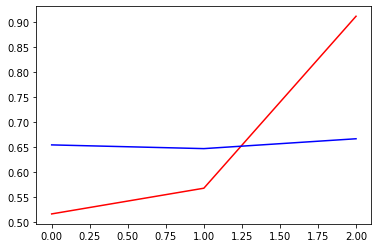

In [62]:
plt.plot(all_class_hist.history['val_loss'], 'r', all_class_hist.history['loss'], 'b')

In [70]:
opt_all_class_hist= classifier.fit_generator(generator=class_tr_gen, steps_per_epoch = 420, epochs=3, verbose=1 , validation_data=class_test_gen, validation_steps=70)

Epoch 1/3
420/420 [==============================] - 279s 665ms/step - loss: 0.6430 - accuracy: 0.6500 - precision_3: 0.6369 - recall_3: 0.6369 - auc_2: 0.6738 - val_loss: 0.5226 - val_accuracy: 0.6571 - val_precision_3: 0.6498 - val_recall_3: 0.6498 - val_auc_2: 0.6763
Epoch 2/3
420/420 [==============================] - 182s 432ms/step - loss: 0.6672 - accuracy: 0.6071 - precision_3: 0.6352 - recall_3: 0.6352 - auc_2: 0.6608 - val_loss: 0.5374 - val_accuracy: 0.5286 - val_precision_3: 0.6266 - val_recall_3: 0.6266 - val_auc_2: 0.6552
Epoch 3/3
420/420 [==============================] - 259s 616ms/step - loss: 0.6423 - accuracy: 0.6500 - precision_3: 0.6283 - recall_3: 0.6283 - auc_2: 0.6588 - val_loss: 0.5361 - val_accuracy: 0.5000 - val_precision_3: 0.6269 - val_recall_3: 0.6269 - val_auc_2: 0.6592


In [0]:
from keras.callbacks import ModelCheckpoint
mcp1_save = ModelCheckpoint('best_classif.h5', save_best_only=True, monitor='val_accuracy', mode='max')
e_s_1= EarlyStopping(monitor='val_loss', mode='min', patience=30)

In [33]:
classif_hist= classifier.fit_generator(generator=class_tr_gen, steps_per_epoch = 420, epochs=50, verbose=1 , callbacks=[mcp1_save,e_s_1], validation_data=class_test_gen, validation_steps=70)

Epoch 1/50
420/420 [==============================] - 217s 518ms/step - loss: 0.9480 - accuracy: 0.6500 - precision: 0.6669 - recall: 0.6669 - auc: 0.6911 - val_loss: 0.7270 - val_accuracy: 0.3714 - val_precision: 0.6286 - val_recall: 0.6286 - val_auc: 0.6509
Epoch 2/50
  2/420 [..............................] - ETA: 36s - loss: 0.2209 - accuracy: 1.0000 - precision: 0.6114 - recall: 0.6114 - auc: 0.6485

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


420/420 [==============================] - 292s 695ms/step - loss: 0.6777 - accuracy: 0.6143 - precision: 0.6145 - recall: 0.6145 - auc: 0.6515 - val_loss: 0.7760 - val_accuracy: 0.3571 - val_precision: 0.6032 - val_recall: 0.6032 - val_auc: 0.6427
Epoch 3/50
420/420 [==============================] - 200s 475ms/step - loss: 0.6569 - accuracy: 0.6524 - precision: 0.6041 - recall: 0.6041 - auc: 0.6460 - val_loss: 0.5863 - val_accuracy: 0.4429 - val_precision: 0.6067 - val_recall: 0.6067 - val_auc: 0.6492
Epoch 4/50
420/420 [==============================] - 301s 717ms/step - loss: 0.6384 - accuracy: 0.6595 - precision: 0.6100 - recall: 0.6100 - auc: 0.6525 - val_loss: 0.5536 - val_accuracy: 0.5000 - val_precision: 0.6134 - val_recall: 0.6134 - val_auc: 0.6560
Epoch 5/50
420/420 [==============================] - 217s 517ms/step - loss: 0.6713 - accuracy: 0.6333 - precision: 0.6118 - recall: 0.6118 - auc: 0.6523 - val_loss: 0.8626 - val_accuracy: 0.4143 - val_precision: 0.6130 - val_reca

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


420/420 [==============================] - 232s 552ms/step - loss: 0.6416 - accuracy: 0.6595 - precision: 0.6043 - recall: 0.6043 - auc: 0.6574 - val_loss: 1.0535 - val_accuracy: 0.3571 - val_precision: 0.6043 - val_recall: 0.6043 - val_auc: 0.6570
Epoch 36/50
420/420 [==============================] - 306s 728ms/step - loss: 0.6189 - accuracy: 0.6786 - precision: 0.6048 - recall: 0.6048 - auc: 0.6576 - val_loss: 1.0575 - val_accuracy: 0.3714 - val_precision: 0.6052 - val_recall: 0.6052 - val_auc: 0.6577
Epoch 37/50
420/420 [==============================] - 199s 474ms/step - loss: 0.6452 - accuracy: 0.6262 - precision: 0.6054 - recall: 0.6054 - auc: 0.6580 - val_loss: 1.0503 - val_accuracy: 0.3143 - val_precision: 0.6046 - val_recall: 0.6046 - val_auc: 0.6571
Epoch 38/50
420/420 [==============================] - 300s 714ms/step - loss: 0.6249 - accuracy: 0.6548 - precision: 0.6047 - recall: 0.6047 - auc: 0.6573 - val_loss: 1.0545 - val_accuracy: 0.3857 - val_precision: 0.6049 - val_r

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
#just to save the model. Don't run again
classifier.save('classifier_1.h5')
model_file = drive.CreateFile({'title' : 'classifier_1.h5'})                       
model_file.SetContentFile('classifier_1.h5')                       
model_file.Upload()

In [66]:

# Don't run again. download to google drive                       
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1HrFpLn6v4ws4xYU8DgYR2XvEk74_xuFp'})

In [0]:
#Loading models from Google Drive into Colab, Don't run

file_obj = drive.CreateFile({'id': '1HrFpLn6v4ws4xYU8DgYR2XvEk74_xuFp'})                       
file_obj.GetContentFile('classifier_1.h5')


In [0]:
from keras.models import load_model
cae=load_model('/content/drive/My Drive/classifier_1.h5')